# Auto Encoder

In [ ]:
def print_distributions(number_of_neurons, data):
  import matplotlib.pyplot as plt
  import seaborn as sns
  
  plt.figure(figsize=(20,20))

  for i in range(number_of_neurons):
    plt.subplot(8,number_of_neurons//8,i+1)
    sns.histplot(data[i])
    
def print_decoder_outputs(input,predictions,number):
  import matplotlib.pyplot as plt
  plt.figure(figsize=(10,3))
  for i in range(number):
    plt.subplot(1,number,i+1)
    plt.axis='off'
    plt.imshow(input[i].reshape(28,28),cmap='gray')
  plt.figure(figsize=(10,3))
  for i in range(number):
    plt.subplot(1,number,i+1)
    plt.axis='off'
    plt.imshow(predictions[i].reshape(28,28),cmap='gray')




In [ ]:
# The motive here is to create an autoencoder

# We will be creating an encoder which will take as input a 32x32 flattened image and then reconstruct it
# using a single layer. 
import warnings
warnings.filterwarnings('ignore')
import keras
from keras import layers
n_dimension=32
input_image=keras.Input(shape=(784,))
encoded_image=layers.Dense(n_dimension,activation='relu')(input_image) # This layer will scale down the image to n_dimension
decoded_image=layers.Dense(784,activation='sigmoid')(encoded_image)

autoencoder_model=keras.Model(input_image,decoded_image)
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


#### Notes
We can see that the model takes as input a flattened image, compresses and encodes it and then reconstruct the image back in the third Dense layer. <br>
While doing the decompression, some information will be lost . 

In [ ]:
# Creating model for encoding

encoder=keras.Model(input_image,encoded_image)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Creating model for decoding
encoded_input=keras.Input(shape=(n_dimension,))
decoder=keras.Model(encoded_input,autoencoder_model.layers[-1](encoded_input))
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [ ]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [ ]:
# Fitting the autoencoder model

autoencoder_model.compile(optimizer='adam',loss='binary_crossentropy')
encoder.compile(optimizer='adam',loss='binary_crossentropy')
decoder.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
import numpy as np
x_train = x_train/ 255.
x_test = x_test/ 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
autoencoder_model.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
235/235 [==============================] - 3s 11ms/step - loss: 0.2738 - val_loss: 0.1891
Epoch 2/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1704 - val_loss: 0.1523
Epoch 3/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1433 - val_loss: 0.1330
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1276 - val_loss: 0.1202
Epoch 5/50
235/235 [==============================] - 2s 11ms/step - loss: 0.1173 - val_loss: 0.1119
Epoch 6/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1104 - val_loss: 0.1063
Epoch 7/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1054 - val_loss: 0.1020
Epoch 8/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1017 - val_loss: 0.0989
Epoch 9/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0990 - val_loss: 0.0966
Epoch 10/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0971 - val_lo

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decode+r.predict(encoded_imgs)


#### Printing the autoencoder outputs with inputs

In [ ]:
gaussian=[[] for i in range(32)] # Storing the outputs of individial neurons to different lists
for image in encoded_imgs:
  i=0
  for neuron_output in image:
    gaussian[i].append(neuron_output)
    i+=1


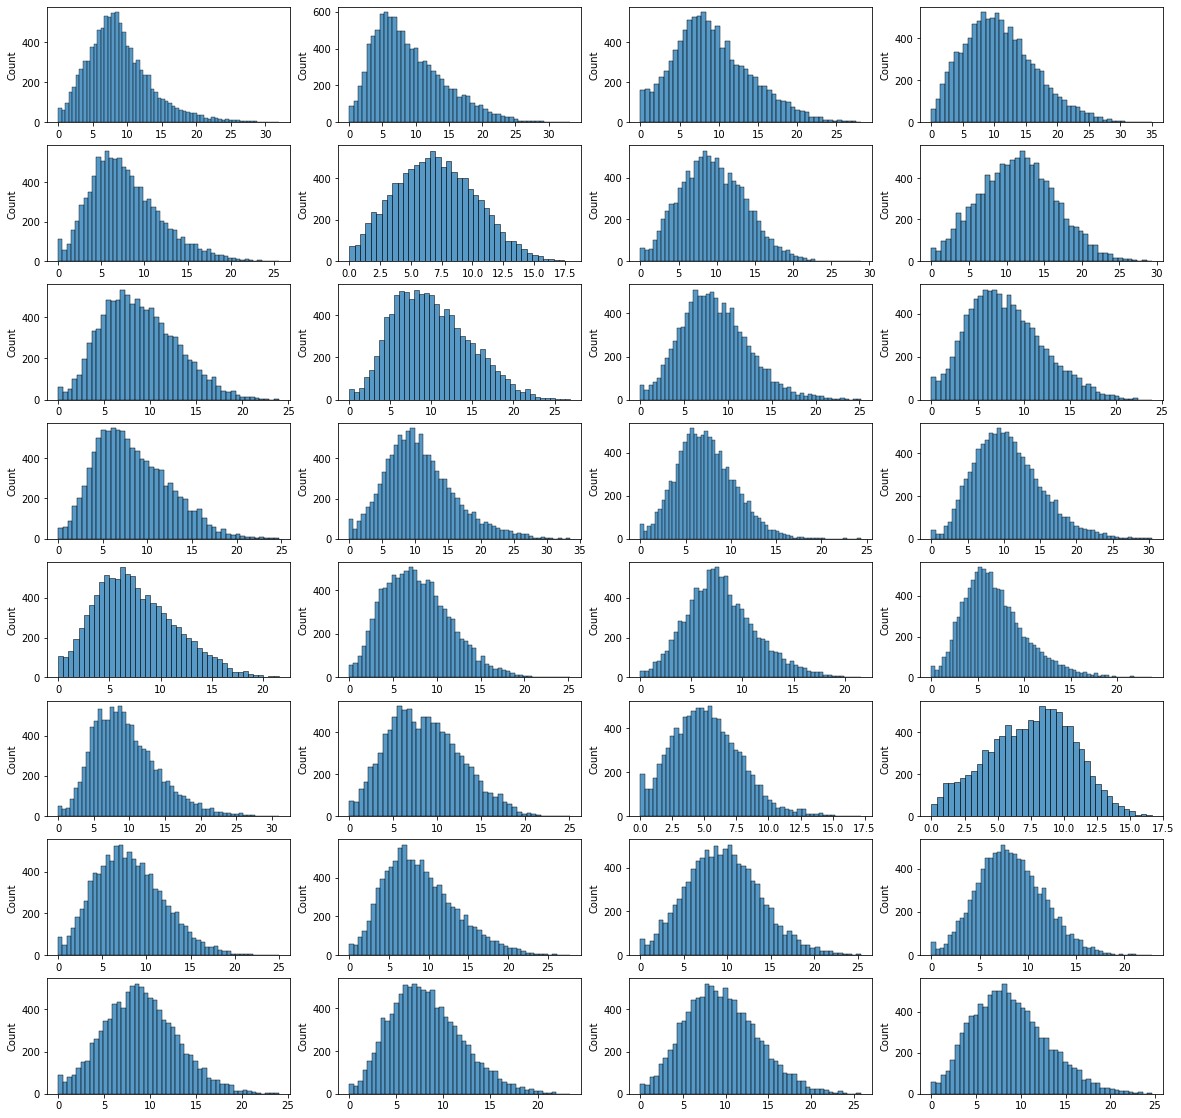

In [ ]:
print_distributions(32,gaussian)

#### From the above plot we can see that for the auto encoder which is created, the distirbutions vary for each neurons. Hence it does not have a standard range of values for each neurons, which we can manually feed to generate the output. Hence ,we are creating a variational auto encoder, with standardised outputs, which will help us to feed inputs manually and generate the data

# Variational Auto Encoder

# Question 1

In [ ]:
from keras import backend as K
inputs=keras.Input(shape=(784,))
hidden=layers.Dense(64,activation='relu')(inputs) # CReating an input layer
z_mean=layers.Dense(2)(hidden) # Creating a layer for mean
z_log_sigma=layers.Dense(2)(hidden) # Creating a layer for standard deviation

def sampling(args): # Function to create samples from a given mean and standard deviation
  z_mean,z_log_sigma=args
  epsilon=K.random_normal(shape=(K.shape(z_mean)[0],2),mean=0.,stddev=0.1)
  return z_mean+K.exp(z_log_sigma)*epsilon

z=layers.Lambda(sampling)([z_mean,z_log_sigma]) # Creating the last layer of encoder



In [ ]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = keras.Input(shape=(2,), name='z_sampling')   # creating the first layer of the decoder network
x = layers.Dense(64, activation='relu')(latent_inputs)
outputs = layers.Dense(784, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')  # Creating a model for the decoder

outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')   # Creating a model for the entire network. This is used to train the model and to see ow well it has performed. 
 

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


## Training the model

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))


Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 185.1754 - val_loss: 166.2379
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 165.2422 - val_loss: 162.9286
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 162.3904 - val_loss: 160.9776
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 160.3126 - val_loss: 159.1880
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 158.8369 - val_loss: 157.9076
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 157.6801 - val_loss: 157.2734
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 156.7297 - val_loss: 156.0791
Epoch 8/100
1875/1875 [==============================] - 7s 3ms/step - loss: 155.9464 - val_loss: 155.6710
Epoch 9/100
1875/1875 [==============================] - 6s 3ms/step - loss: 155.2426 - val_loss: 155.0859
Epoch 10/100
1875/1875 [=============

## Doing prediction and checking how effectve the prediction is


In [ ]:
test_encoded=encoder.predict(x_test)

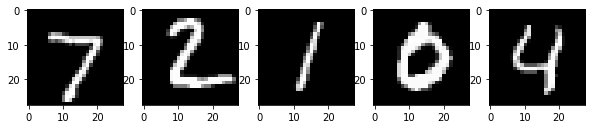

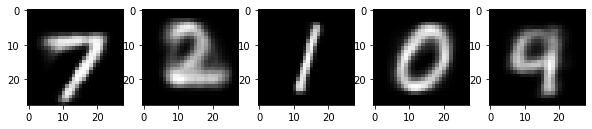

In [ ]:
print_decoder_outputs(x_test,vae.predict(x_test),5)

#### The images are predicted, although some differences can be seen. The accuracy is lower than the first network because there are only two latent layers. So there can be information loss during the encoding-decoding process

In [ ]:
def plot_distribution(number,latent_layers,start=0,stop=10):
  """ Function to plot the distribution of data
  if number=1, mean will be plotted
  if number=2, std will be plotted
  if number=3, z will be plotted
  """
  words={1:'One',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine',0:'Zero'}
  # Finding the index of different numbers in the dataset
  position=[[] for i in range(10)]
  for i,element in enumerate(y_test):
    position[element].append(i)
  
  import matplotlib.pyplot as plt
  import seaborn as sns
  for j in range(start,stop):
    data=[test_encoded[number][i] for i in position[j]]
    gaussian_data=[[] for i in range(latent_layers)]
    for output in data:
      for i in range(latent_layers):
          gaussian_data[i].append(output[i])

    plt.figure(figsize=(15,3))
    for i in range(latent_layers):
      plt.title(str('Encoding layer distribution for ')+str(words[j]))
      plt.subplot(1,latent_layers+1,i+1)
      sns.histplot(gaussian_data[i],kde=True,bins=100)

def plot_all_distribution(number,latent_layers):
  """ Function to plot the distribution of data
  if number=1, mean will be plotted
  if number=2, std will be plotted
  if number=3, z will be plotted
  """
  words={1:'One',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine',0:'Zero'}
  # Finding the index of different numbers in the dataset
  position=[[] for i in range(10)]
  for i,element in enumerate(y_test):
    position[element].append(i)
  
  import matplotlib.pyplot as plt
  import seaborn as sns
  data=test_encoded[number]
  gaussian_data=[[] for i in range(latent_layers)]
  for output in data:
    for i in range(latent_layers):
      gaussian_data[i].append(output[i])

  plt.figure(figsize=(15,3))
  for i in range(latent_layers):
    plt.title(str('Encoding layer distribution for all outputs'))
    plt.subplot(1,latent_layers+1,i+1)
    sns.histplot(gaussian_data[i],kde=True,bins=100)

## Distibution for all outputs

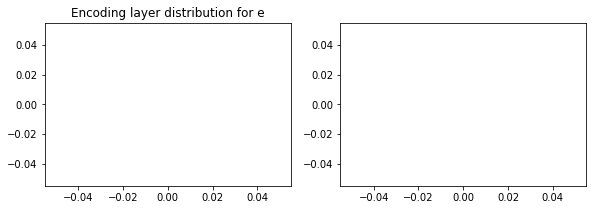

In [ ]:
position=[[] for i in range(10)]
for i,element in enumerate(y_test):
  position[element].append(i)
latent_layers=2
words='Test'
import matplotlib.pyplot as plt
import seaborn as sns
for j in range(0,2):
  data=[test_encoded[0][i] for i in position[j]]
  mean=[[] for i in range(latent_layers)]
  for output in data:
    for i in range(latent_layers):
        mean[i].append(output[i])
for j in range(0,2):
  data=[test_encoded[1][i] for i in position[j]]
  std=[[] for i in range(latent_layers)]
  for output in data:
    for i in range(latent_layers):
        std[i].append(output[i])
for j in range(0,2):
  data=[test_encoded[2][i] for i in position[j]]
  z=[[] for i in range(latent_layers)]
  for output in data:
    for i in range(latent_layers):
        z[i].append(output[i])
from scipy.stats import norm
import statistics
plt.figure(figsize=(15,3))
for i in range(latent_layers):
  plt.title(str('Encoding layer distribution for ')+str(words[j]))
  plt.subplot(1,latent_layers+1,i+1)
  x=np.linspace(-3,3,len(mean[0]))
  plt.plot(x,norm.pdf(x,mean[0],std[0]))

In [ ]:
mean[0][0],std[0][0]

(-0.7686443, -1.3884351)

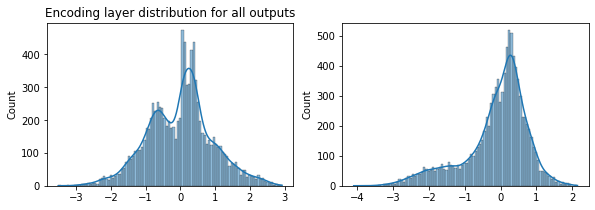

In [ ]:

plot_all_distribution(2,2)

## Individual Distribution for outputs from 0 to 9

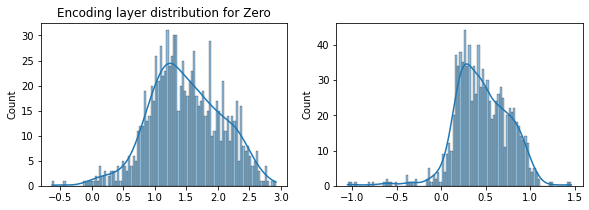

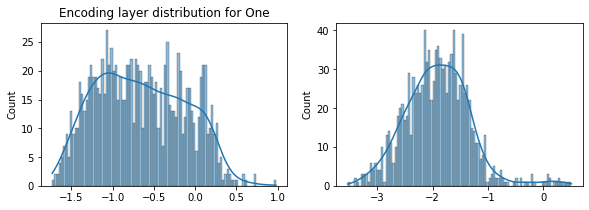

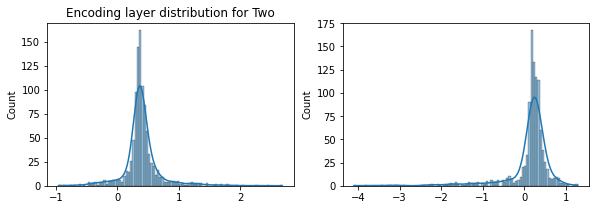

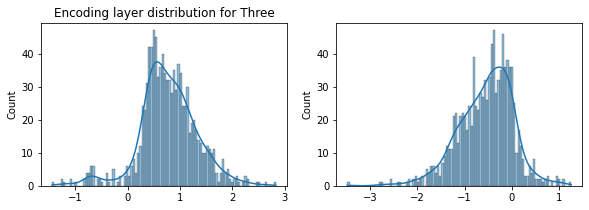

In [ ]:

plot_distribution(2,2,0,4)

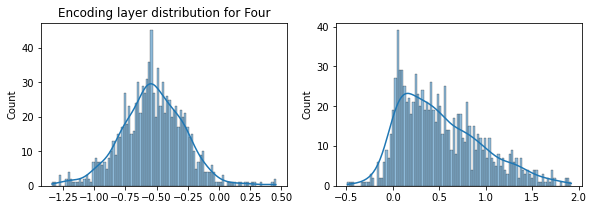

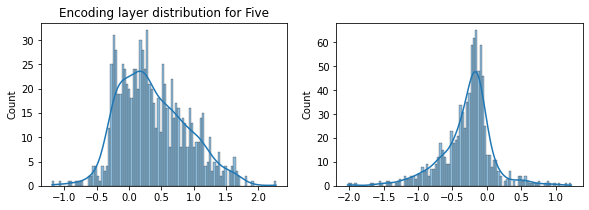

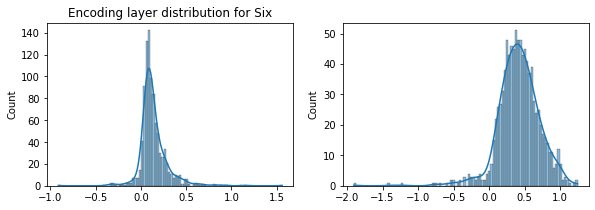

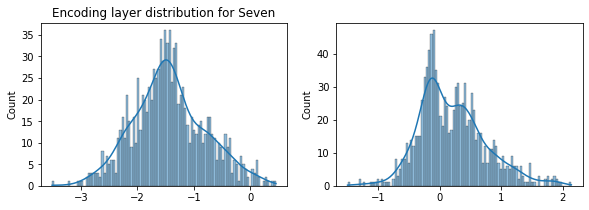

In [ ]:

plot_distribution(2,2,4,8)

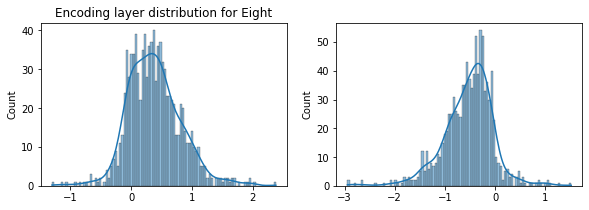

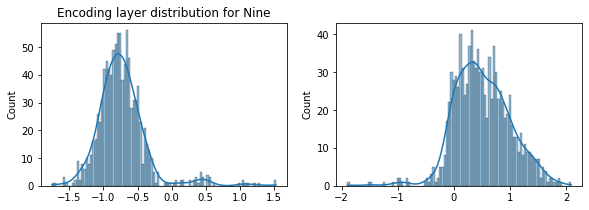

In [ ]:

plot_distribution(2,2,8,10)

## Trying to generate inputs by feeding these values from the disrtibution to the decoder network

Distribution for 9 and 4 have peak at similar regions because they look similar. 

Similar for 9 and 7

8 and 6 seems to have similar peaks as the shape is also somewhat similar


# Finding the influence if the two latent variables in the output


In [ ]:
def identify_impact(decoded_model,range,variable=0):
  """ If variable =0, it identifies the impact of the first latent variable
      if variable==1, it identifis the impact of the second latent variable 
      and so on 
      
      decoded_model is the decoder model
      range is the min and max values of the distribution
  """
  import numpy as np
  import matplotlib.pyplot as plt
  values=np.linspace(range[0],range[1],10)
  plt.figure(figsize=(30,5))
  count=1
  for val in values:
    if variable==0:
      output=decoder.predict([[val,0]])
    elif variable==1:
      output=decoder.predict([[0,val]])
    plt.subplot(1,10,count)
    plt.imshow(output.reshape(28,28))
    count+=1

def identify_all_impact(decoded_model):
  """ If variable =0, it identifies the impact of the first latent variable
      if variable==1, it identifis the impact of the second latent variable 
      and so on 
      
      decoded_model is the decoder model
      range is the min and max values of the distribution
  """
  import numpy as np
  import matplotlib.pyplot as plt
  values=np.linspace(-7,3,8)
  values1=np.linspace(-7,3,8)
 
  count=1
  plt.figure(figsize=(20,20))
  plt.axis='off'
  for val in values:
    for val1 in values1:
      output=decoder.predict([[val,val1]])
      plt.subplot(8,8,count)
      plt.imshow(output.reshape(28,28))
      count+=1


# Question 2

#### Impact of changing the first latent variable keeping the seocnd one constant at 0

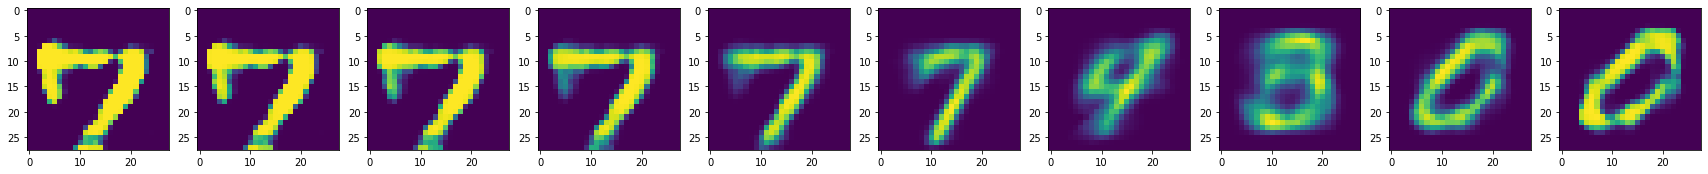

In [ ]:
identify_impact(decoder,[-7,3],0)

#### Impact of changing the second latent keeping the first one constant at 0

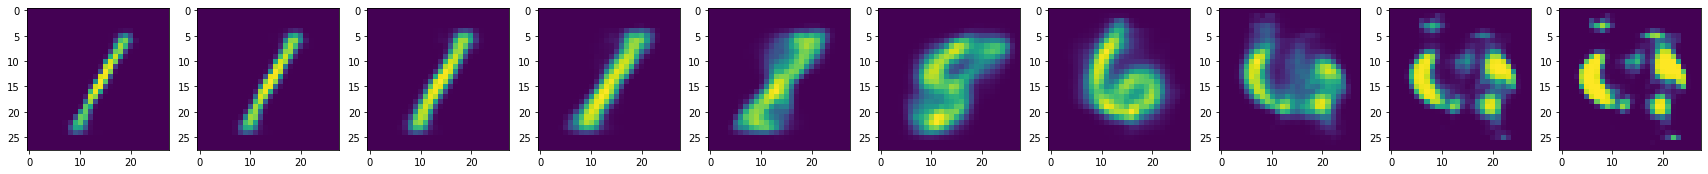

In [ ]:
identify_impact(decoder,[-4,3],1)

### Impact of changing the both the latent variables and observing the change in output. 

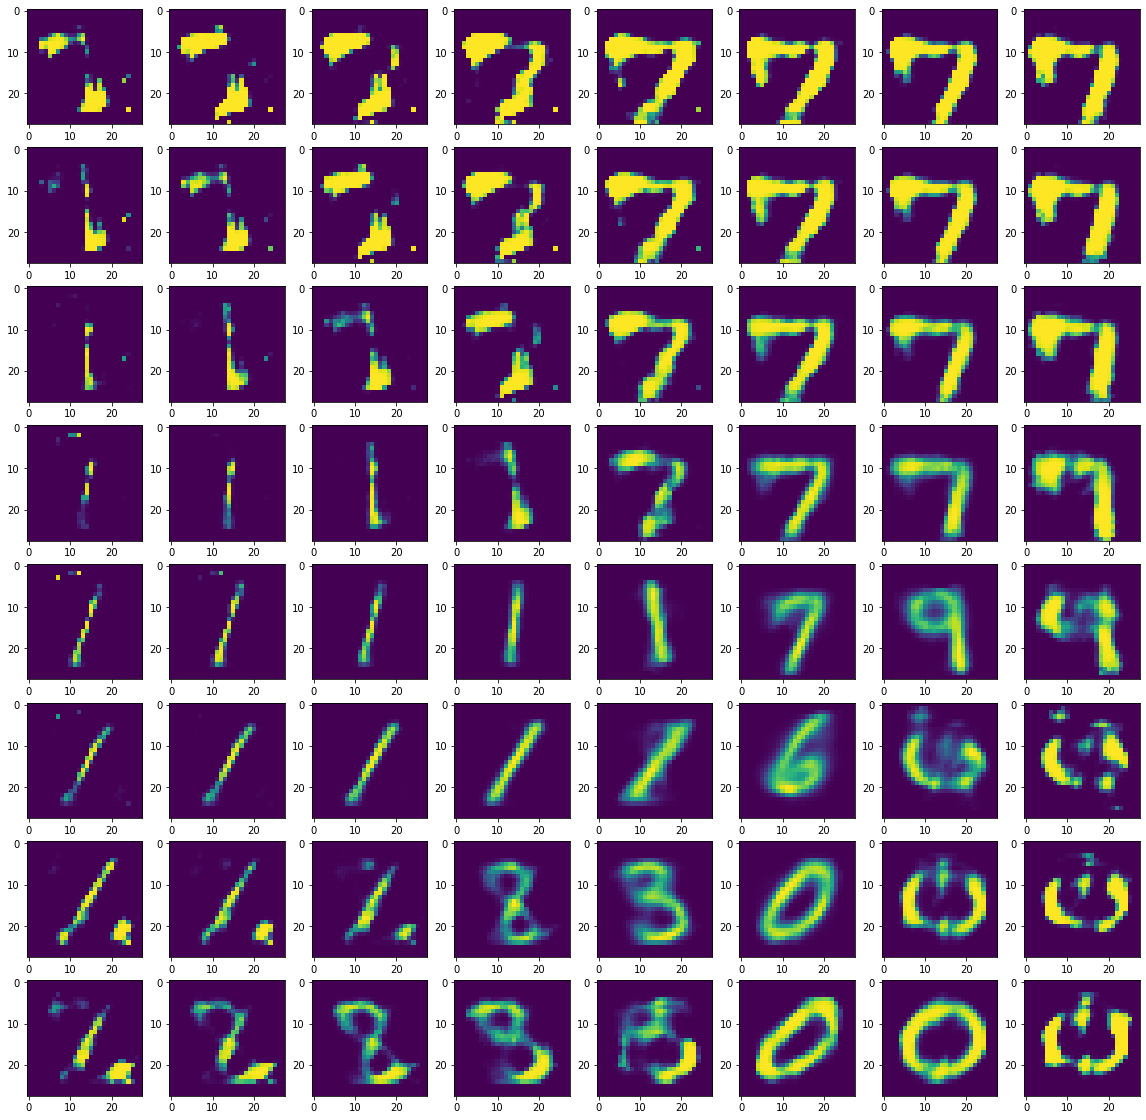

In [ ]:
identify_all_impact(decoder)

### From the above predictions it can be seen that each numbers have a different distribution. 
- The range for the entire decoder input varies from -7 to 3 and -4 to 3 for the two latent variables respectively. 
- Each numbers also have their own respective distributions. 
- If we feed a number which lies between the range of two numbers, we will get some value which look similar to both of them. Eg : 4th Row and 4th column provides a shape which looks like a 7 and a 9
- However, if we provide a value out of the range of the input range for the decoder, the output will start to deteriorate as in the last image of the above graph where 5 starts loosing its shape and begins to distort. 
